In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision.models

In [2]:
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 102MB/s]


In [3]:
torch.manual_seed(1)

In [4]:
#only want the filter weights, not the classifier
convalexnet = alexnet.features

convalexnet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
test_folder = '/content/drive/MyDrive/Demo/Small_Split_Extracted/content/Blood_Cell_Dataset_Small_Split/test'

In [7]:
import torchvision.transforms as transforms
transform = transforms.Compose(
        [ #resize all images to height and width of 280
         transforms.ToTensor(),        #transform images to tensors
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ['basophil', 'neutrophil', 'ig', 'monocyte', 
               'eosinophil', 'erythroblast', 'lymphocyte', 'platelet']

test_data = torchvision.datasets.ImageFolder(test_folder, transform=transform)

print(len(test_data))

200


In [8]:
import torch.utils.data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1, shuffle=True)

In [9]:
class proposed2(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(proposed2, self).__init__()
        #self.fc = nn.Linear(10*256*7*7 + hidden_size*3, num_class) #temp sizes, idk what the dimensions should be
        #256*7*7 for alexnet, 512*8*8 for vgg16
        self.name = "Proposed2"
        #also how many classes are there?
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        self.fcCNN = nn.Linear(256*7*7, 60) #64*34*34 #192*16*16 #192*34*34
        self.fcRNN = nn.Linear(hidden_size, 60)
        self.fc = nn.Linear(60+60, num_class)
    def forward(self, x):
        #y = torch.flatten(x, 1)
        #print(x.size())
        #if use_cuda:
          #convalexnet.cuda()
        #convalexnet=convalexnet.to(device)
        cnnpath = convalexnet(x) #convgg16(x)
        #cnnpath = torch.flatten(cnnpath, 1) #x = x.view(-1, 512*8*8) #maybe this one? but idk dimensions
        
        x = torch.flatten(x, 2,3) #x.view(-1, 78400) #2352000?
        x = x.permute(1, 0, 2) 
        h0 = torch.zeros(1, len(x), self.hidden_size)
        #if use_cuda:
        h0=h0.to(device)
        #print("test",x.size(dim=0), x.dim)
        #print(h0.size, h0.dim)
        rnnpath, __=self.rnn(x, h0)
        #print(rnnpath.shape) #swap dimensions

        rnnpath = rnnpath[-1,:,:]
        #print(cnnpath.shape, rnnpath.shape)

        cnnpath = torch.flatten(cnnpath, 1)
        cnnpath = F.relu(self.fcCNN(cnnpath))
        rnnpath = F.relu(self.fcRNN(rnnpath))
        #print(cnnpath.shape, rnnpath.shape)
        

        merged = torch.cat((cnnpath, rnnpath),1)
        #print(merged.shape)
        x = self.fc(merged)

        return x

In [10]:
input_size = 78400
hidden_size = 64 #this needs to be the hidden size of the model you chose
num_class = 8
demo_net = proposed2(input_size, hidden_size, num_class)
model_path = "/content/drive/MyDrive/Demo/model_h64_bs64_lr0.005_epoch7" # the path of the model you chose
state = torch.load(model_path)
demo_net.load_state_dict(state)

<All keys matched successfully>

In [11]:
use_cuda = True
device = "cuda"
demo_net.to(device)
convalexnet.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

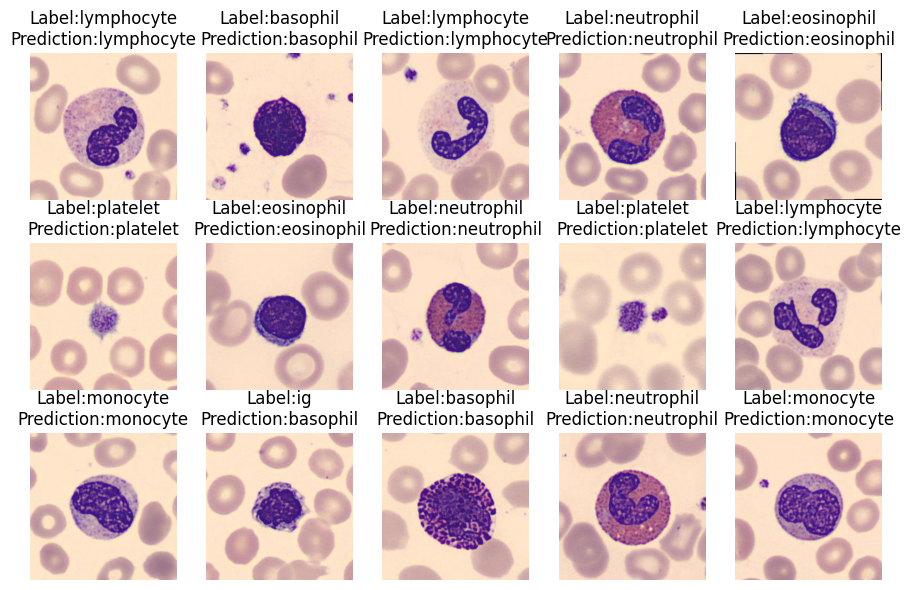

In [16]:
import numpy as np
import matplotlib.pyplot as plt

n = 0
for image, label in test_loader:

  if use_cuda and torch.cuda.is_available():
              image = image.cuda()
              label = label.cuda()

  single_output = demo_net(image)     #generate an array of probabilities for each class
  pred = single_output.max(1, keepdim=True)[1]  #determine the class that is predicted

  plt.subplot(3, 5, n+1)
  img = image.cpu()[0]
  imgx = np.transpose(img, [1,2,0])
  imgx = imgx / 2 + 0.5   #normalize values
  plt.rcParams['figure.figsize'] = [11, 7]    #resize
  plt.imshow(imgx)
  plt.axis('off')
  plt.title('Label:' + classes[label[0]] + '\nPrediction:' + classes[pred[0]])

  n = n + 1

  if n > 14:
    break